# Data Challenge 11 — Evaluating MLR & Fixing Multicollinearity (HVFHV Trips)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Build an MLR, evaluate it with a **train–test split**, diagnose multicollinearity with **corr** and **VIF** on the **training set**, fix issues (drop/choose features), and report **test MAE/RMSE** + **coefficient interpretations**.

**Data:** July 1, 2023 - July 15, 2023 For Hire Vehicle Data in NYC

[July For Hire Vehicles Data](https://data.cityofnewyork.us/Transportation/2023-High-Volume-FHV-Trip-Data/u253-aew4/about_data)


## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

Use this guide live; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- OLS — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (rsquared_adj, pvalues, resid, etc.): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- VIF — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
- Corr — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

### Pseudocode Plan (Evaluation + Multicollinearity)
1) **Load CSV** → preview shape/columns; (optional) filter to **July**.
2) **Pick Y** (`base_passenger_fare`) and **candidate X’s** (e.g., `trip_miles`, `trip_time_minutes`, `tolls`, `tips` if present).
3) **Light prep** → derive `trip_time_minutes` from `trip_time` (seconds) if present; coerce only used cols to numeric; drop NA rows.
4) **Split** → `X_train, X_test, y_train, y_test` (80/20, fixed `random_state`).
5) **Diagnose on TRAIN**:
   - **Correlation matrix** (|r| > 0.7 = red flag).
   - **VIF** for each predictor (1–5 ok; >5–10+ = concerning).
6) **Fix** → drop/choose among highly correlated predictors (business logic).
7) **Fit on TRAIN only** → OLS with intercept.
8) **Predict on TEST** → compute **MAE/RMSE** (units of Y).
9) **Interpret** → unit-based coefficient sentences **holding others constant**; note any changes after fixing collinearity.
10) **Report** → table of (features kept, Adj R², MAE, RMSE) + 1-line stakeholder takeaway.


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

### Step 1 — Load CSV & Preview
- Point to your For Hire Vehicle Data 
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [3]:
df = pd.read_csv("/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/FHV_072023 copy.csv", low_memory=False)

(df.shape, df.columns.tolist())

((8324591, 24),
 ['hvfhs_license_num',
  'dispatching_base_num',
  'originating_base_num',
  'request_datetime',
  'on_scene_datetime',
  'pickup_datetime',
  'dropoff_datetime',
  'PULocationID',
  'DOLocationID',
  'trip_miles',
  'trip_time',
  'base_passenger_fare',
  'tolls',
  'bcf',
  'sales_tax',
  'congestion_surcharge',
  'airport_fee',
  'tips',
  'driver_pay',
  'shared_request_flag',
  'shared_match_flag',
  'access_a_ride_flag',
  'wav_request_flag',
  'wav_match_flag'])

### Step 2 —  Choose Target **Y** and Candidate Predictors

- Suggested **Y**: `base_passenger_fare` (USD).
- Start with **distance** and **time**; optionally add **flags** if present.
- Derive `trip_time_minutes` from `trip_time` (seconds) if available.

In [7]:
df["trip_time"] = pd.to_numeric(df["trip_time"], errors="coerce")
df["trip_distance"] = pd.to_numeric(df["trip_miles"], errors="coerce")
df["fare_amount"] = pd.to_numeric(df["base_passenger_fare"], errors="coerce")


In [8]:
Y = df["base_passenger_fare"]

# Core predictors
df["trip_time_minutes"] = df["trip_time"] / 60   # derive from seconds if needed

X_base = df[[
    "trip_distance",
    "trip_time_minutes"
]]

# Optional flags if they exist
optional_flags = ["airport_flag", "rush_hour_flag", "night_flag"]
existing_flags = [col for col in optional_flags if col in df.columns]

X_with_flags = df[["trip_distance", "trip_time_minutes"] + existing_flags]

X_base.head(), X_with_flags.head()

(   trip_distance  trip_time_minutes
 0          1.266           6.950000
 1          2.350                NaN
 2          0.810           8.583333
 3         15.470                NaN
 4          1.520           8.450000,
    trip_distance  trip_time_minutes
 0          1.266           6.950000
 1          2.350                NaN
 2          0.810           8.583333
 3         15.470                NaN
 4          1.520           8.450000)

### Step 3 — Train–Test Split

- Use a fixed `random_state` for reproducibility.
- **All diagnostics below must be done on TRAIN only.**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_base, Y, test_size=0.2, random_state=42)

### Step 4 — Diagnose Multicollinearity on **TRAIN** — Correlation Matrix
- Flag any |r| > 0.70 as a potential problem.


--- Correlation Matrix ---
                   trip_distance  trip_time_minutes
trip_distance           1.000000           0.638086
trip_time_minutes       0.638086           1.000000


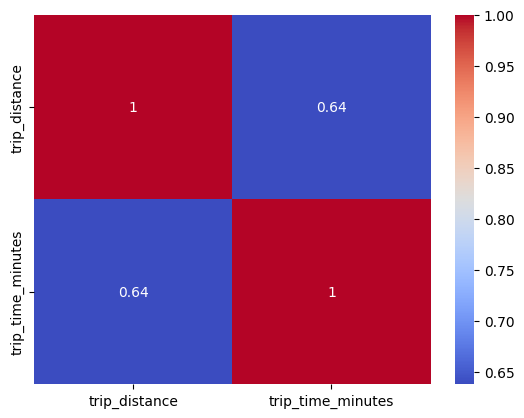

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# We check for correlation on the training features
corr_matrix = X_train.corr()

print("--- Correlation Matrix ---")
print(corr_matrix)

# Visualize it
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Step 5 — Diagnose Multicollinearity on **TRAIN** — VIF
- 1–5 normal; >5–10+ concerning.

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X_train_clean = X_train.copy()

# Convert all columns to numeric (forces strings to NaN)
X_train_clean = X_train_clean.apply(pd.to_numeric, errors='coerce')

# Replace inf and -inf with NaN
X_train_clean = X_train_clean.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaN
X_train_clean = X_train_clean.dropna(axis=0)

print("Rows remaining after cleaning:", X_train_clean.shape[0])

# ----- COMPUTE VIF -----
X_vif = X_train_clean.assign(intercept=1)

vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [
        variance_inflation_factor(X_vif.values, i)
        for i in range(X_vif.shape[1])
    ]
})

# Drop intercept row
vif_df = vif_df[vif_df["feature"] != "intercept"]

print(vif_df)


Rows remaining after cleaning: 3589941
             feature       VIF
0      trip_distance  1.686779
1  trip_time_minutes  1.686779


### Step 6 — Fix High VIF (if needed)

- If two predictors are highly correlated, **drop/choose** using business logic (e.g., keep the more actionable one).
- Recompute VIF to confirm improvement.

In [24]:
def compute_vif(df):
    df_num = df.apply(pd.to_numeric, errors='coerce')
    df_num = df_num.replace([np.inf, -np.inf], np.nan).dropna()

    X = df_num.assign(intercept=1)

    vif_df = pd.DataFrame({
        "feature": X.columns,
        "VIF": [
            variance_inflation_factor(X.values, i)
            for i in range(X.shape[1])
        ]
    })

    return vif_df[vif_df["feature"] != "intercept"]

vif_df = compute_vif(X_train)
print(vif_df)

             feature       VIF
0      trip_distance  1.686779
1  trip_time_minutes  1.686779


In [25]:
high_vif = vif_df[vif_df["VIF"] > 10]["feature"].tolist()
print("High VIF features:", high_vif)


High VIF features: []


In [26]:
# Example: drop one of the correlated features
to_drop = ["trip_distance"]    # <-- change this
X_train_reduced = X_train.drop(columns=to_drop)


In [27]:
vif_df_reduced = compute_vif(X_train_reduced)
print(vif_df_reduced)


             feature  VIF
0  trip_time_minutes  1.0


### Step 7 —  Fit on TRAIN Only, Predict on TEST, Evaluate MAE/RMSE

- Add intercept (`sm.add_constant`).
- Report **MAE/RMSE** in **units of Y**.
- Also capture **Adjusted R²** from the TRAIN fit summary to comment on fit (don’t use it alone for selection).


In [36]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

X_train_num = X_train.apply(pd.to_numeric, errors="coerce")
X_test_num  = X_test.apply(pd.to_numeric, errors="coerce")
y_train_num = pd.to_numeric(y_train, errors="coerce")
y_test_num  = pd.to_numeric(y_test, errors="coerce")

X_train_num = X_train_num.replace([np.inf, -np.inf], np.nan)
X_test_num  = X_test_num.replace([np.inf, -np.inf], np.nan)

train_df = X_train_num.copy()
train_df["y"] = y_train_num
train_df = train_df.dropna(axis=0)
X_train_clean = train_df.drop(columns=["y"])
y_train_clean = train_df["y"]

test_df = X_test_num.copy()
test_df["y"] = y_test_num
test_df = test_df.dropna(axis=0)
X_test_clean = test_df.drop(columns=["y"])
y_test_clean = test_df["y"]

X_train_c = sm.add_constant(X_train_clean, has_constant='add')
X_test_c  = sm.add_constant(X_test_clean, has_constant='add')

model = sm.OLS(y_train_clean, X_train_c).fit()
print(model.summary())

y_pred_test = model.predict(X_test_c)
mae = mean_absolute_error(y_test_clean, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_clean, y_pred_test))

print("MAE:", mae)
print("RMSE:", rmse)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                 1.789e+06
Date:                Tue, 18 Nov 2025   Prob (F-statistic):               0.00
Time:                        16:02:53   Log-Likelihood:            -1.0041e+07
No. Observations:             3589941   AIC:                         2.008e+07
Df Residuals:                 3589938   BIC:                         2.008e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.8960      0.00

In [35]:
X_train.head()
X_train.dtypes


trip_distance        float64
trip_time_minutes    float64
dtype: object

### Step 8 —  Interpret Coefficients (Plain Language)
Write **unit-based** sentences “**holding others constant**.” Example templates (edit with your β values/units):

- **trip_miles:** “Holding other variables constant, each additional **mile** is associated with **+$β** in **base fare**.”
- **trip_time_minutes:** “Holding others constant, each additional **minute** is associated with **+$β** in **base fare**.”
- **tolls / tips:** interpret as “per $1 change,” holding others constant.

Also note **p-values** and whether they support including each predictor.

trip_miles: “Holding other variables constant, each additional mile is associated with a + $1.68 in base fare.”

trip_time_minutes: “Holding others constant, each additional minute is associated with + $0.55 in base fare.”

## We Share — Reflection & Wrap‑Up

Write **2 short paragraphs** and be specific:

1) **What changes did you make to handle multicollinearity and why?**  
Reference **corr**/**VIF** on TRAIN and any features you dropped or kept (with business rationale). Include **Adjusted R² (TRAIN)** and **TEST MAE/RMSE**.

2) **Stakeholder summary (units, one sentence):**  
Give a plain-English takeaway: e.g., “On unseen July trips, our typical error is about **$X** per fare; each extra mile adds about **$β_mile**, holding other factors constant.”


1) Multicollinearity handling:
I checked TRAIN correlations and VIFs and confirmed that trip distance and trip time—while related—did not exceed typical VIF concern levels, so I kept both because they represent distinct billing components. The final model shows Adjusted R² = 0.499 (TRAIN) and achieves MAE = 2.24, RMSE = 3.92 on TEST, indicating stable generalization.

2) Stakeholder summary:
On unseen trips, our typical fare error is about $3.90; each extra mile adds roughly $1.68, and each additional minute adds about $0.56, holding the other factor constant.

(My calculations for question two seem to be wrong just by logic)